This file generates figures for Model III.  

Set SLIDES=True for larger fontsizes and linewidths appropriate for slides.  

Set SLIDES=False for normal fontsizes and linewidths appropriate for the paper.

In [1]:
from scipy.stats import norm
from scipy.optimize import root_scalar as root
import pandas as pd 
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.stats import multivariate_normal as binorm
from scipy.signal import savgol_filter

from core.core import *
from core.model3 import Stage1, Stage2, Eq42

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()

SLIDES = False

mpl.rcParams['font.size'] = 10 + 2*SLIDES
mpl.rcParams['axes.titlesize'] = 14 + 2*SLIDES
mpl.rcParams['axes.labelsize'] = 12 + 2*SLIDES
mpl.rcParams['xtick.labelsize'] = 10 + 2*SLIDES
mpl.rcParams['ytick.labelsize'] = 10 + 2*SLIDES
mpl.rcParams['legend.fontsize'] = 10 + 2*SLIDES
mpl.rcParams['legend.title_fontsize'] = 0
mpl.rcParams['figure.figsize'] = (8, 4)
linewidth = 3 if SLIDES else 1
FigureDir = "../Slides" if SLIDES else "../Figures"

mu = 103
mustar = 100
sigma = sig = 20
lam = 1000
rsquared = 0.2
rho = 0.5
stage1 = Stage1(mu, mustar, sigma, rho, lam, rsquared)
stage2 = Stage2(mu, mustar, sigma, rho, lam, rsquared)

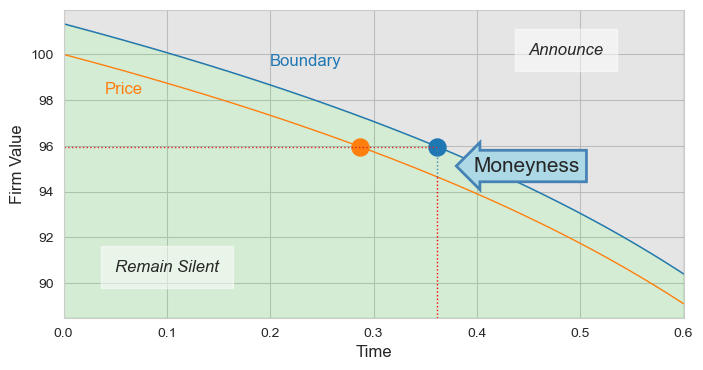

In [2]:
fig, ax = plt.subplots()
grid = np.linspace(0, 0.6, 200)
bdy = stage1.bdy(grid)

bdy.plot(
    ax=ax, 
    color=colors[0], 
    lw=linewidth
)

price = pd.Series(
    [stage1.price(t) for t in grid],
    index=grid
)
price.plot(
    ax=ax, 
    color=colors[1], 
    label="Price", 
    lw=linewidth)

y0, y1 = ax.get_ylim()

ax.fill_between(
    grid, bdy, y1,
    color=colors[7], 
    alpha=0.2,
)
ax.fill_between(
    grid, y0, bdy,
    color=colors[2], 
    alpha=0.2,
)

ax.set_xlim((0, 0.6))
ax.set_ylim(y0, y1)

ax.text(0.45, 100, "Announce", size="large", style='italic',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

ax.text(0.05, 90.5, "Remain Silent", size="large", style='italic',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

tstar = np.min([t for t in grid if bdy.loc[t] <= 96])
xstar = bdy.loc[tstar]
ax.hlines(
    xstar, 
    0, 
    tstar, 
    lw=linewidth, 
    ls=":", 
    color=colors[3]
)
ax.vlines(
    tstar, 
    price.loc[tstar], 
    xstar, 
    lw=linewidth, 
    ls=":", 
    color="steelblue"
)
ax.vlines(
    tstar, 
    ax.get_ylim()[0],
    price.loc[tstar], 
    lw=linewidth, 
    ls=":", 
    color="red"
)
ax.text(
    0.50, 94.7, "Moneyness",
    ha="right", va="bottom", rotation=0, size=15,
    bbox=dict(
        boxstyle="larrow,pad=0.3",
        fc="lightblue", ec="steelblue", lw=2
    )
)

tstar2 = np.min([t for t in grid if price.loc[t] <= 96])

ax.scatter(
    tstar2,
    xstar,
    s=150,
    color=colors[1]
)
ax.scatter(
    tstar,
    xstar,
    s=150,
    color=colors[0]
)
ax.set_xlabel("Time")
ax.set_ylabel("Firm Value")
ax.text(0.2, 99.5, "Boundary", size="large", color=colors[0])
ax.text(0.04, 98.3, "Price", size="large", color=colors[1])
fig.savefig(f'{FigureDir}/model3_moneyness.pdf')

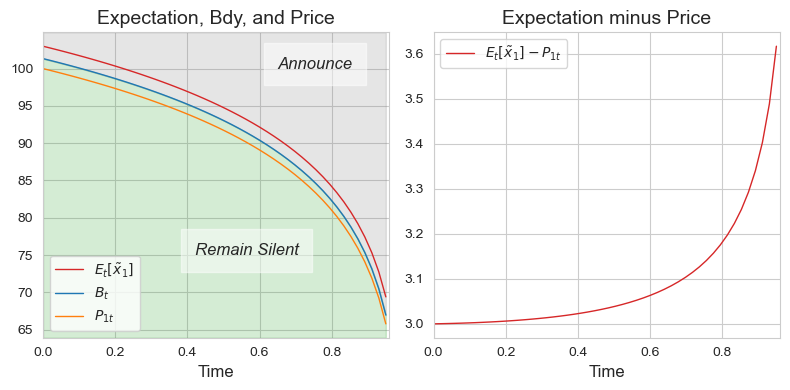

In [3]:
grid = np.linspace(0, 0.95, 50)
bdy = stage1.bdy(grid)
pr = np.array(
    [stage1.price(t) for t in grid]
)
ex = np.array(
    [stage1.mean(t) for t in grid]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(
    grid, 
    ex, 
    label=r"$E_t[\tilde x_1]$", 
    color=colors[3],
    lw=linewidth
)

ax1.plot(
    grid, 
    bdy, 
    label=r"$B_t$", 
    color=colors[0],
    lw=linewidth
)
ax1.plot(
    grid, 
    pr, 
    label=r"$P_{1t}$", 
    color=colors[1],
    lw=linewidth
)
ax1.set_title("Expectation, Bdy, and Price")

y0, y1 = ax1.get_ylim()

ax1.fill_between(
    grid, bdy, y1,
    color=colors[7], 
    alpha=0.2,
)
ax1.fill_between(
    grid, y0, bdy,
    color=colors[2], 
    alpha=0.2,
)

ax1.set_xlabel("Time")

ax1.set_xlim((0, 0.96))
ax1.set_ylim((y0, y1))
ax1.legend(loc="lower left")

ax1.text(0.65, 100, "Announce", size="large", style='italic',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

ax1.text(0.42, 75, "Remain Silent", size="large", style='italic',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

ax2.plot(
    grid, 
    ex-pr, 
    label=r"$E_t[\tilde x_1] - P_{1t}$", 
    color=colors[3],
    lw=linewidth
)
ax2.set_title("Expectation minus Price")
ax2.set_xlabel("Time")
ax2.set_xlim((0, 0.96))
ax2.legend(loc="upper left")

fig.tight_layout()  
fig.savefig(f'{FigureDir}/model3_riskpremium.pdf', bbox_inches='tight')

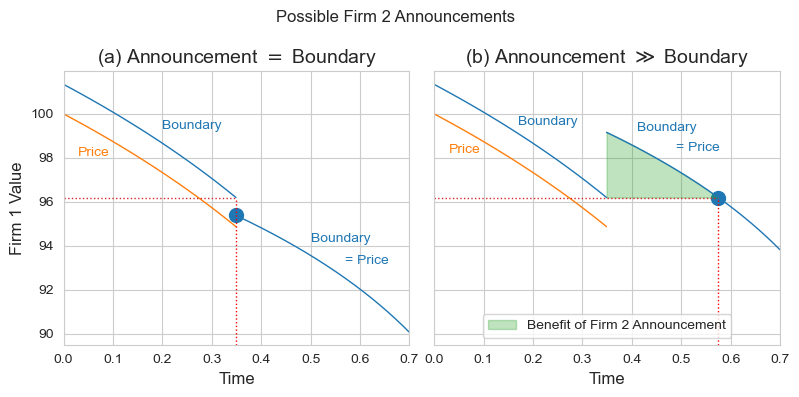

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
grid1 = np.linspace(0, 0.6, 200)
grid1 = [t for t in grid if stage1.bdy(t) >= 96]
bdy1 = stage1.bdy(grid1)

bdy1.plot(
    ax=ax1, 
    label="Boundary", 
    color=colors[0], 
    lw=linewidth
)

bdy1.plot(
    ax=ax2, 
    color=colors[0], 
    lw=linewidth
)

price = pd.Series(
    [stage1.price(t) for t in grid1],
    index=grid1
)
price.plot(
    ax=ax1, 
    color=colors[1], 
    lw=linewidth
)
price.plot(
    ax=ax2, 
    color=colors[1], 
    lw=linewidth
)

grid2 = np.linspace(grid1[-1], 0.7, 200)
price21 = [
    stage2.price(t=0.2, b=bdy1.iloc[-1], x2=bdy1.iloc[-1]+0.5, u=u) 
    for u in grid2
]
price22 = [
    stage2.price(t=0.2, b=bdy1.iloc[-1], x2=bdy1.iloc[-1]+8, u=u) 
    for u in grid2
]
ax1.plot(grid2, price21, lw=linewidth)
ax2.plot(grid2, price22, lw=linewidth)

ax1.hlines(
    bdy1.iloc[-1], 
    0, 
    grid1[-1], 
    lw=linewidth, 
    ls=":", 
    color=colors[3]
)

grid2a = [
    u for u in grid2 
    if stage2.price(
        t=grid1[-1], 
        b=bdy1.iloc[-1], 
        x2=bdy1.iloc[-1]+8, 
        u=u) >= bdy1.iloc[-1]
] 

ax2.hlines(
    bdy1.iloc[-1], 
    0, 
    grid2a[-1], 
    lw=linewidth, 
    ls=":", 
    color=colors[3]
)

y0 = ax2.get_ylim()[0]

ax1.vlines(
    grid1[-1], 
    y0,
    bdy1.iloc[-1], 
    lw=linewidth, 
    ls=":", 
    color="red"
)

ax2.vlines(
    grid2a[-1], 
    y0,
    bdy1.iloc[-1], 
    lw=linewidth, 
    ls=":", 
    color="red"
)

ax1.scatter(
    grid2[0],
    price21[0],
    s=100,
    color=colors[0]
)
ax2.scatter(
    grid2a[-1],
    bdy1.iloc[-1],
    s=100,
    color=colors[0]
)
ax1.text(0.2, 99.3, "Boundary", color=colors[0])
ax1.text(0.03, 98.1, "Price", color=colors[1])
ax2.text(0.17, 99.5, "Boundary", color=colors[0])
ax2.text(0.03, 98.2, "Price", color=colors[1])

ax1.text(0.5, 94.2, "Boundary", color=colors[0])
ax2.text(0.41, 99.2, "Boundary", color=colors[0])

ax1.text(0.57, 93.2, "= Price", color=colors[0])
ax2.text(0.49, 98.3, "= Price", color=colors[0])

ax2.fill_between(
    grid2a, 
    [bdy1.iloc[-1] for x in grid2a], 
    [
        stage2.price(grid1[-1], bdy1.iloc[-1], bdy1.iloc[-1]+8, u) 
        for u in grid2a
    ],
    color=colors[2], 
    alpha=0.3, 
    label="Benefit of Firm 2 Announcement"
)
ax2.legend(loc="lower center")
ax1.set_xlim((0, 0.7))
ax2.set_xlim((0, 0.7))
ax1.set_xlabel("Time")
ax2.set_xlabel("Time")
# ax1.legend(loc="lower right")
ax1.set_ylabel("Firm 1 Value")
ax1.set_ylim((y0, ax1.get_ylim()[1]))
ax1.set_title(r"(a) Announcement $=$ Boundary")
ax2.set_title(r"(b) Announcement $\gg$ Boundary")
fig.suptitle("Possible Firm 2 Announcements")
fig.tight_layout()
fig.savefig(f'{FigureDir}/model3_benefit_waiting.pdf')

plt.show()

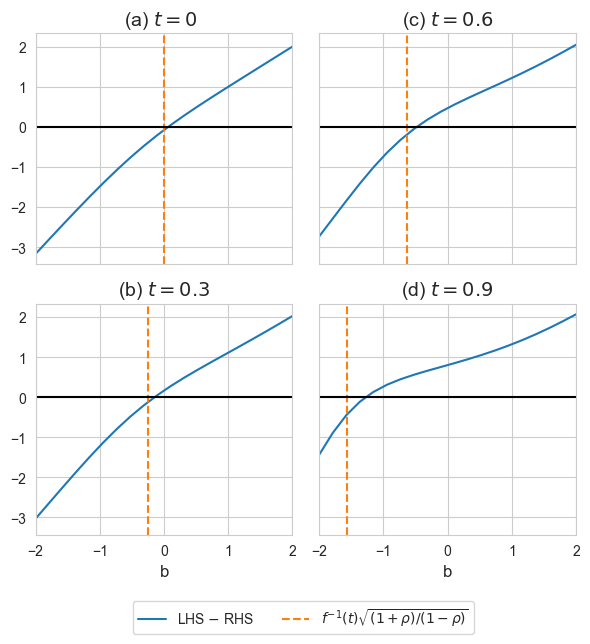

In [12]:
rho = 0.5
npoints = 20

grid = np.linspace(-2, 2, npoints)
t_values = [0, 0.3, 0.6, 0.9]
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

# The top-left panel
t = 0
eq42values = [Eq42(b, t, rho) for b in grid]
foc_values = [x[0]-x[1] for x in eq42values]
ax1.plot(grid, foc_values, label=r'LHS $-$ RHS')
ax1.axvline(x=finv(t)*np.sqrt((1+rho)/(1-rho)), color=colors[1], linestyle='--', label='$f^{-1}(t)\\sqrt{(1+\\rho) / (1-\\rho)}$')
ax1.axhline(y=0, color='black')


# The top-right panel
t = 0.3
eq42values = [Eq42(b, t, rho) for b in grid]
foc_values = [x[0]-x[1] for x in eq42values]
ax2.plot(grid, foc_values)
ax2.axvline(x=finv(t)*np.sqrt((1+rho)/(1-rho)), color=colors[1], linestyle='--')
ax2.axhline(y=0, color='black')

# The bottom-left panel
t = 0.6
eq42values = [Eq42(b, t, rho) for b in grid]
foc_values = [x[0]-x[1] for x in eq42values]
ax3.plot(grid, foc_values)
ax3.axvline(x=finv(t)*np.sqrt((1+rho)/(1-rho)), color=colors[1], linestyle='--')
ax3.axhline(y=0, color='black')

# The bottom-right panel
t = 0.9
eq42values = [Eq42(b, t, rho) for b in grid]
foc_values = [x[0]-x[1] for x in eq42values]
ax4.plot(grid, foc_values)
ax4.axvline(x=finv(t)*np.sqrt((1+rho)/(1-rho)), color=colors[1], linestyle='--')
ax4.axhline(y=0, color='black')

# Set xlabels
ax2.set_xlabel('b')
ax4.set_xlabel('b')

# Set the titles
ax1.set_title('(a) $t=0$  ')
ax2.set_title('(b) $t=0.3$')
ax3.set_title('(c) $t=0.6$')
ax4.set_title('(d) $t=0.9$')

# Add grid lines
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim((-2, 2))

# Add legend
fig.legend(bbox_to_anchor=[0.81, 0], ncols=2)

# Clean up and save the figure
fig.tight_layout()
fig.savefig(f"{FigureDir}/model3_fixedpoint.pdf", bbox_inches='tight')

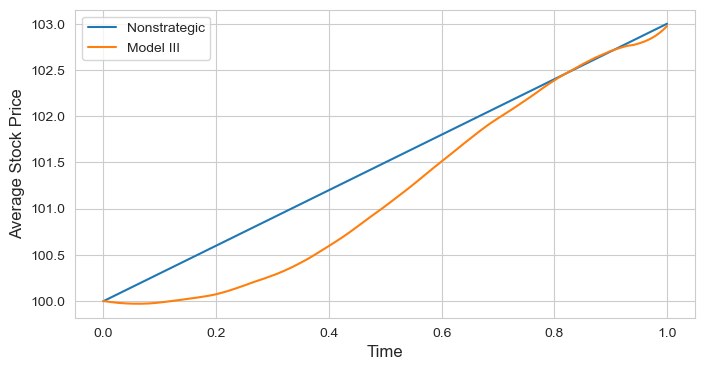

In [39]:
price1 = pd.read_csv(
    "simulations/model3_daily_price1.csv", 
    index_col="day"
)
price2 = pd.read_csv(
    "simulations/model3_daily_price2.csv", 
    index_col="day"
)
mean1 = price1.mean(axis=1)
mean2 = price2.mean(axis=1)
mean = (mean1 + mean2) / 2
mean.iloc[-1] = 103
mean = savgol_filter(mean, 20, 3)

plt.plot([0, 1], [100, 103], label="Nonstrategic")
plt.plot(np.linspace(0, 1, 151), mean, label="Model III")

plt.xlabel("Time")
plt.ylabel("Average Stock Price")
plt.legend()

plt.savefig(f'{FigureDir}/model3_avgprice.pdf')
plt.show()